## Projet BIP :
### Objectifs :

Developer une méthode pour localiser les noeuds d'arbre dans une image en déterminant leurs caractéristiques : taille , eccentricité .

In [106]:
import matplotlib.pyplot as plt
import skimage.io as io 
from scipy.ndimage import binary_fill_holes
from skimage.color import rgb2gray,label2rgb
from skimage.filters import sobel,threshold_otsu,threshold_li,median,gaussian,prewitt
from scipy.ndimage import label as lb
from skimage.measure import regionprops,label,regionprops_table
import skimage.morphology as morpho
import numpy as np
import os
import matplotlib.patches as mpatches
from skimage.filters import threshold_local
from skimage.filters import gaussian
from skimage import img_as_float


In [4]:
def read_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg')):  
            img_path = os.path.join(folder_path, filename)
            img = io.imread(img_path)
            img=rgb2gray(img)  
            if img is not None:
                images.append(img)  # Add the image to the list
    return images


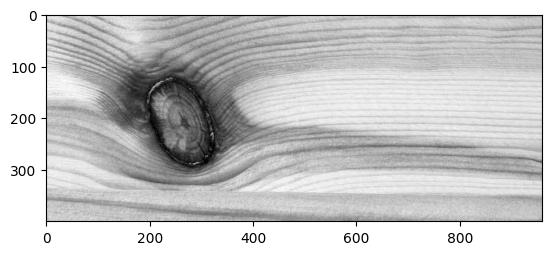

In [5]:
folder_path = './Image_data'
image_dataset = read_images_from_folder(folder_path)
plt.imshow(image_dataset[0],'gray')

In [2]:
def thresholding(image):
    threshold_max=(image).max()
    threshold=threshold_max*0.4
    #threshold = threshold_local(image, block_size, offset=0)
    img_gauss = gaussian(image, sigma=1)
    mask=img_gauss < threshold 
    nv_mask=binary_fill_holes(mask)
    op = morpho.binary_opening(nv_mask)
    label_image = label(op)
    regions = regionprops(label_image)
    filtered_regions = []
    for region in regions:
        if region.area > 10 and 0 <= region.eccentricity < 0.3:
            filtered_regions.append({
            'centroid': region.centroid,
            'bbox': region.bbox
            })
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title('image avec bounding box sur les noeuds')
    ax.imshow(image,'gray')
    for region in regionprops(label_image):
        if 300<region.area < 425000 and 0 <=region.eccentricity < 0.8:
             minr, minc, maxr, maxc = region.bbox
             
             rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
             ax.add_patch(rect)
             centroid = region.centroid
             ax.plot(centroid[1], centroid[0], 'ro', markersize=5)  
    
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    fig=plt.figure()
    plt.title('mask de binarisation ')
    plt.imshow(label_image)
    plt.show()
    return filtered_regions

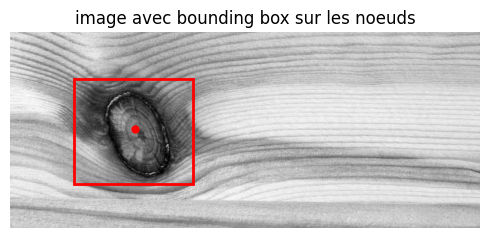

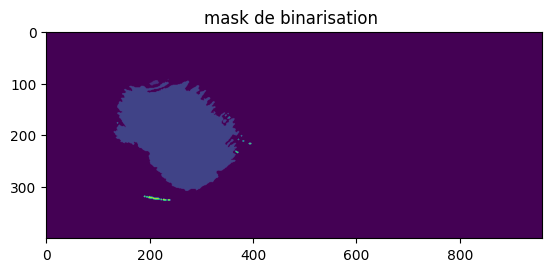

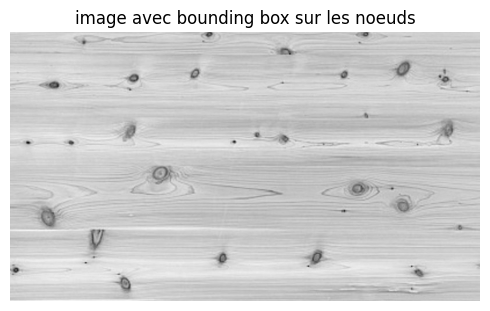

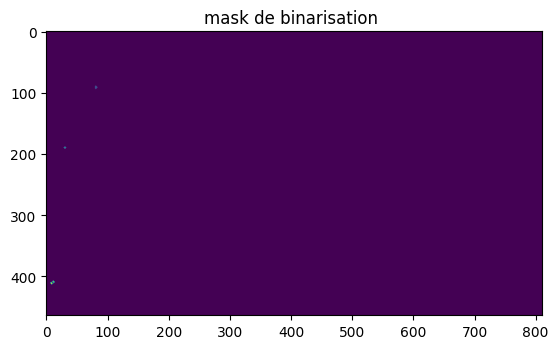

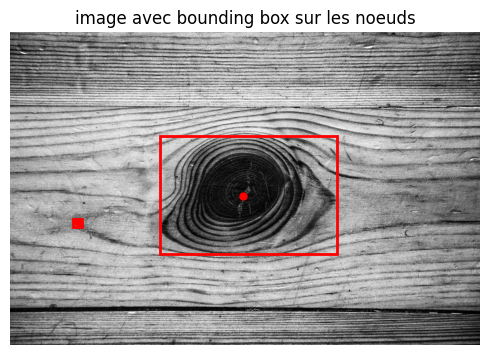

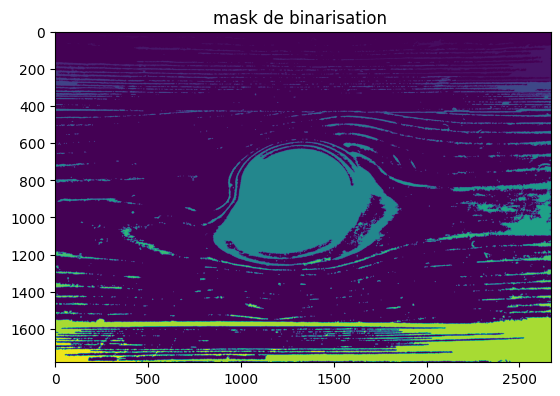

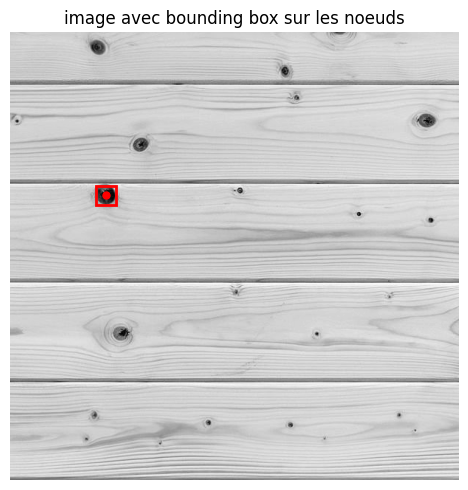

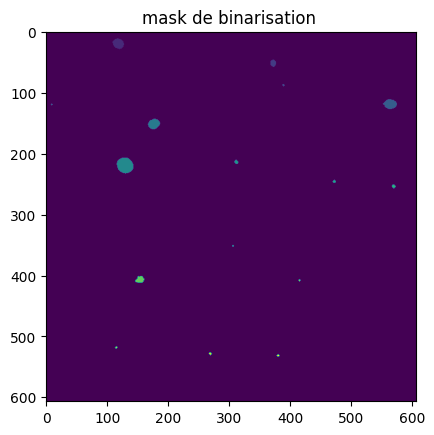

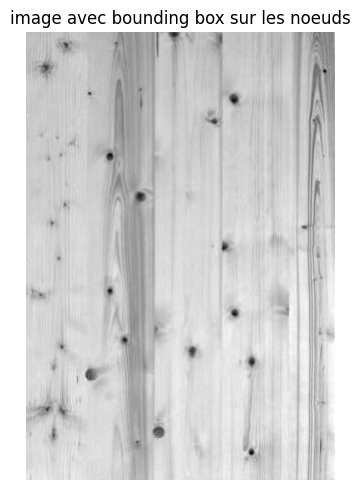

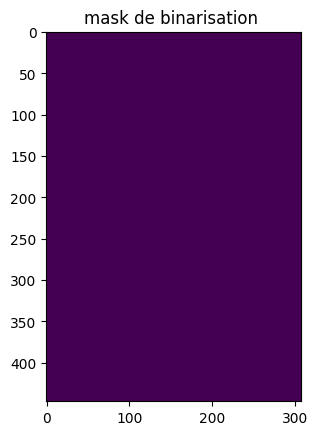

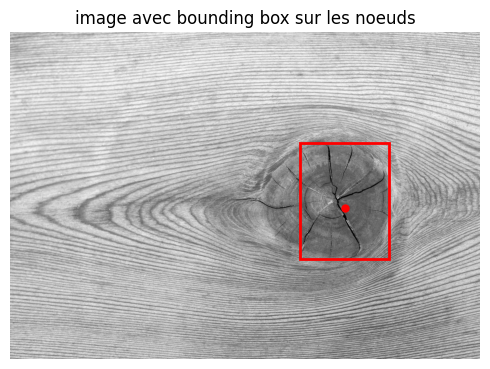

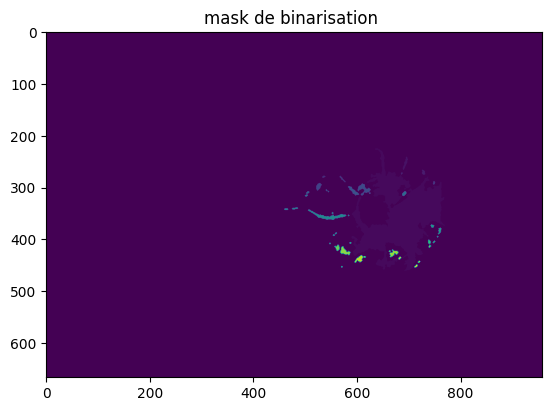

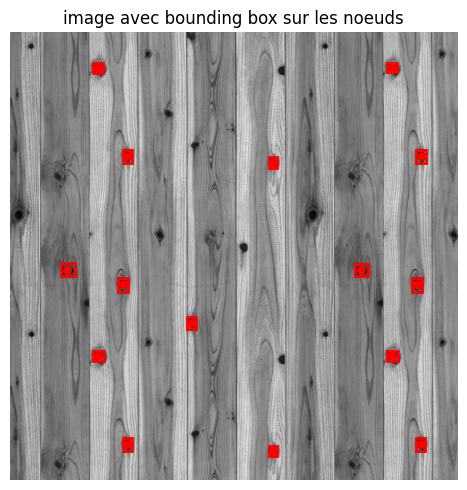

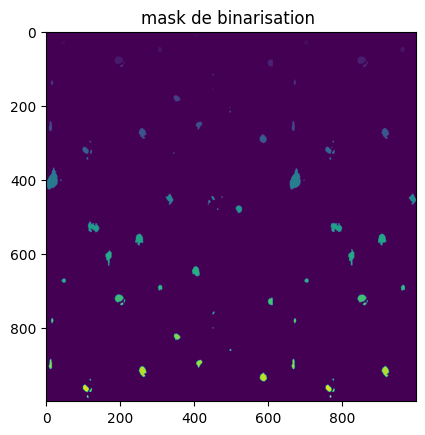

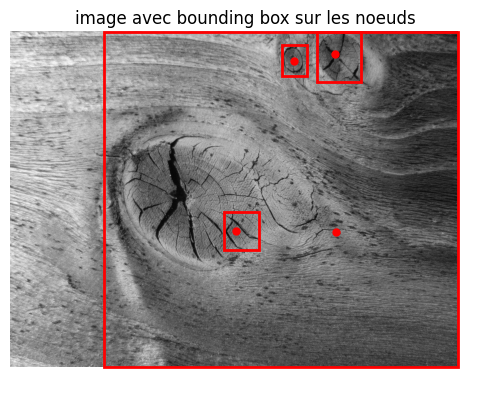

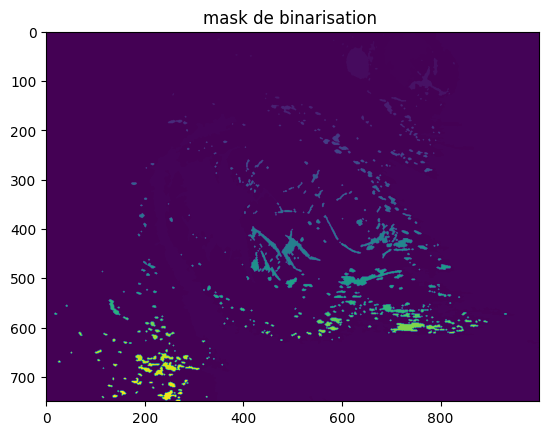

In [163]:
List_properties=[]
for i in range(len(image_dataset)):
    image=image_dataset[i]
    filtered_regionpts=thresholding(image)
    List_properties.append(filtered_regionpts)

## Critiques :
La méthode implementée en haut procède à une segmentation directe de l'image avec la valeur t cependant cette approche ne donne pas déjà une bonne detection de tout les noeuds dans l'image ceci est liée à :

Méthode de seuillage : le suillage utilisée est une méthode simple mais pas optimale si l'éclairage et le contraste varient beaucoup --> filtrage adaptatif --> local variations
L'image 3 et l'image 8 montrent bien ce fait




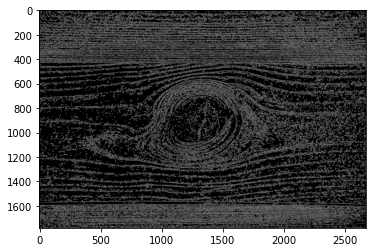

In [119]:
from skimage import feature
img=image_dataset[2]
m=sobel(img)
egdes=feature.canny(m,sigma=1)
plt.imshow(egdes,'gray')

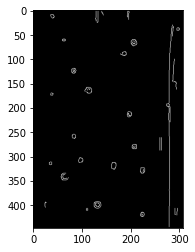

In [121]:
img=image_dataset[4]
m=sobel(img)
egdes=feature.canny(m)
plt.imshow(egdes,'gray')

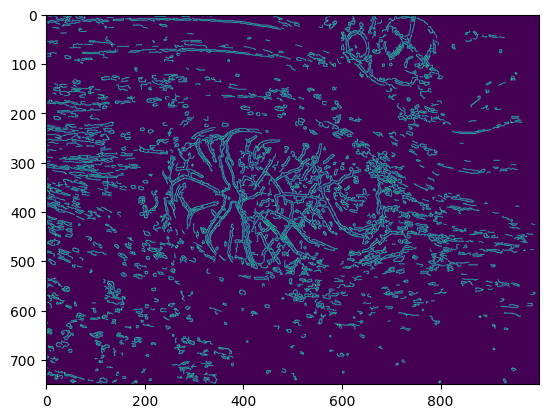

In [17]:
from skimage import feature
img=image_dataset[7]
#img=gaussian(img)
img=sobel(img)

#t=threshold_otsu(img)
#mask=img > t

#watershed_image = watershed(img)
egdes=feature.canny(img)
#egdes=morpho.dilation(egdes,morpho.disk(2))

plt.imshow(egdes)
#egdes=binary_fill_holes(egdes)
#label_image=label(egdes)
#dl=morpho.erosion(label_image,morpho.disk(2))



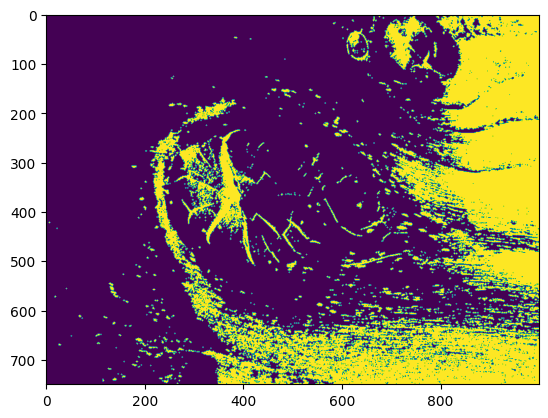

In [101]:
img=image_dataset[7]
#img=median(img,morpho.disk(3))
mask=img<threshold_otsu(img,4)
egdes=morpho.opening(mask,morpho.disk(1))

plt.imshow(egdes)


C:\Users\moham\AppData\Local\Temp\ipykernel_14256\2722910531.py:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  histogram, bin_edges = np.histogram(im_float_threshold, bins=256, range=(0, 1))


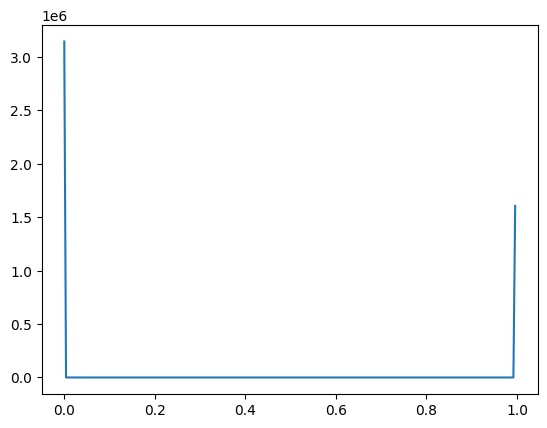

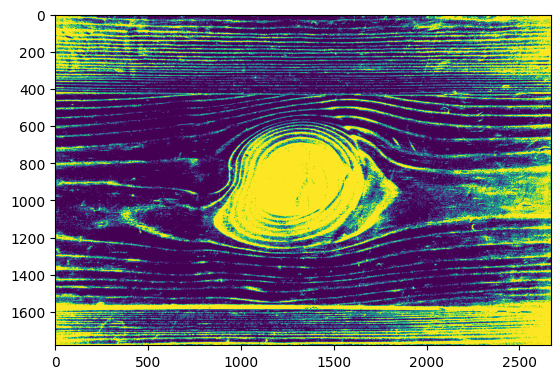

In [126]:
img=image_dataset[2]
im_float = img_as_float(img)
#histogram, bin_edges = np.histogram(im_float, bins=256, range=(0, 1))

im_float_threshold = im_float < threshold_otsu(im_float)
histogram, bin_edges = np.histogram(im_float_threshold, bins=256, range=(0, 1))
plt.plot(bin_edges[0:-1], histogram)
plt.show()
plt.imshow(im_float_threshold)
plt.show()